## In this notebook we attempt to train state of the art models such as [YOLOv8](https://docs.ultralytics.com/models/yolov8/) for real-time [instance segmentation](https://docs.ultralytics.com/tasks/segment/) on the [cityscapes dataset](https://www.cityscapes-dataset.com).

### Loading dataset: In order to access the [cityscapes dataset](https://www.cityscapes-dataset.com), you have to create an account. The dataset contains thousands of images with high quality pixel annotations (semantic segmentation and instance segmentation for vehicle and people). The images are of urban street scenes across various cities (taken from a driver's POV). Annotations in json files are in the form of [polygon annotations](https://www.ayadata.ai/blog-posts/what-is-polygon-annotation-and-how-does-it-work/).

In [ ]:
!python -m pip install cityscapesscripts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.9 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=8fb93a7b4bbebccae177efa346d59862065f45a8196f1dac308a87d4fb6b59fc
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [ ]:
# Create data directory
from pathlib import Path
data_dir = Path("data")

if data_dir.is_dir():
  print("Data directory already exists")

else:
  print("Data directory does not exist, creating one...")
  data_dir.mkdir(parents=True, exist_ok=True)

Data directory does not exist, creating one...


In [ ]:
!csDownload -d "data" gtFine_trainvaltest.zip

Cityscapes username or email address: purplelord2003
Cityscapes password: 
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y


In [ ]:
from zipfile import ZipFile

with ZipFile("data/gtFine_trainvaltest.zip", "r") as zip_ref:
  zip_ref.extractall("data")

In [ ]:
!rm data/gtFine_trainvaltest.zip

In [ ]:
!csDownload -d "data" leftImg8bit_trainvaltest.zip

In [ ]:
with ZipFile("data/leftImg8bit_trainvaltest.zip", "r") as zip_ref:
  zip_ref.extractall("data")

In [ ]:
!rm data/leftImg8bit_trainvaltest.zip

## Lets view how a sample looks like in the dataset

In [ ]:
import matplotlib.pyplot as plt
import PIL

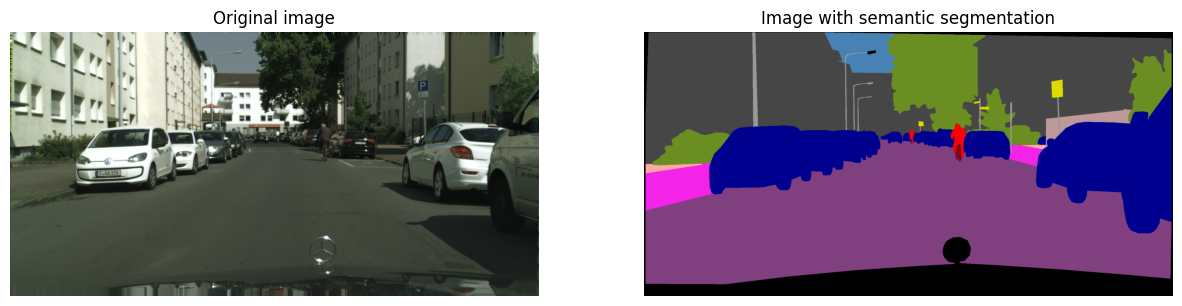

In [ ]:
fig = plt.figure(figsize=(15, 10))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)

plt.imshow(PIL.Image.open("data/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png"))
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(PIL.Image.open("data/gtFine/val/frankfurt/frankfurt_000000_000576_gtFine_color.png"))
plt.axis('off')
plt.title("Image with semantic segmentation")

plt.show()

## Now we will do arguably one of the harder parts of data preparation - to convert all the png images and json annotations into YOLO format for training

In [ ]:
# make yolo dir
yolo_dir = Path("yolo")

if yolo_dir.is_dir():
  print("Yolo data directory already exists")

else:
  print("Yolo data directory does not exist, creating one...")
  yolo_dir.mkdir(parents=True, exist_ok=True)

Yolo data directory does not exist, creating one...


In [ ]:
# make train, test, val folders and the images, labels folders in each folder
for split in ["train", "test", "val"]:
  if not Path(yolo_dir / split).is_dir():
    Path(yolo_dir / split).mkdir(parents=True, exist_ok=True)
    Path(yolo_dir / split / "images").mkdir(parents=True, exist_ok=True)
    Path(yolo_dir / split / "labels").mkdir(parents=True, exist_ok=True)

### We will be using the following 19 classes for training as recommended by the creators: https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py. Though some classes like the sky is not really meant for instance segmentation (differentiating within the same class), I would still like to see the model attempt to mask such classes regardless.

In [ ]:
classes = [
'road',
'sidewalk',
'building',
'wall',
'fence',
'pole',
'traffic light',
'traffic sign',
'vegetation',
'terrain',
'sky',
'person',
'rider',
'car',
'truck',
'bus',
'train',
'motorcycle',
'bicycle',
]

In [ ]:
len(classes)

19

In [ ]:
from pathlib import Path
import shutil
import json
from tqdm.auto import tqdm

In [ ]:
# Copying images and annotations (convert to txt) to new directory of YOLO formatting
for split in ["test", "train", "val"]:
  list_of_annotations = sorted(Path(f"data/gtFine/{split}").glob("**/*.json"))

  for jsonfilepath in tqdm(list_of_annotations):
    path_piece = Path(jsonfilepath.parent.stem) / (jsonfilepath.stem.removesuffix("_gtFine_polygons") + "_leftImg8bit.png")
    image_path = Path(f"data/leftImg8bit/{split}") / path_piece
    shutil.copy2(src=image_path, dst=f"yolo/{split}/images")

    text_path = Path(f"yolo/{split}/labels") / (image_path.stem.removesuffix(".png") + ".txt")
    with open(text_path, "w") as f:
      infile = open(jsonfilepath)
      data = json.load(infile)
      height = data["imgHeight"]
      width = data["imgWidth"]
      for object_dict in data["objects"]:
        idx = object_dict["label"]

        if idx in classes:
            f.write(str(classes.index(idx)))
            for coordinates in object_dict["polygon"]:
              coordinates[0] /= width
              coordinates[1] /= height
              f.write(f" {coordinates[0]} {coordinates[1]}")
            f.write("\n")



  0%|          | 0/1525 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Delete the data directory (we will only need the new directory)
!rm -r "data"

## Importing YOLOv8 segmentation model
Decided to use the small version (as it provides faster inference speeds with quite good accuracy metrics). You can check out the different types of segmentation models [here]("https://docs.ultralytics.com/tasks/segment/#models").

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 15.3 MB/s eta 0:00:00


In [ ]:
model = YOLO('yolov8s-seg.pt')

100%|██████████| 22.8M/22.8M [00:00<00:00, 373MB/s]


In [ ]:
# Importing a yaml file that I created beforehand as required for YOLO formatting
!wget -P "yolo" https://github.com/purplelord2003/Segmentation-Model/raw/main/Model%20Training%20and%20Testing/cityscapes.yaml

--2024-02-14 15:51:27--  https://github.com/purplelord2003/Segmentation-Model/raw/main/cityscapes.yaml
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/purplelord2003/Segmentation-Model/main/cityscapes.yaml [following]
--2024-02-14 15:51:27--  https://raw.githubusercontent.com/purplelord2003/Segmentation-Model/main/cityscapes.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 671 [text/plain]
Saving to: ‘yolo/cityscapes.yaml’

cityscapes.yaml     100%[===================>]     671  --.-KB/s    in 0s      

2024-02-14 15:51:27 (72.1 MB/s) - ‘yolo/cityscapes.yaml’ saved [671/671]



### Training for 50 epochs (training will stop if no improvement over 25 epochs), also the hyperparameters and data augmentation is automatically done in this user-friendly interface.

In [ ]:
results = model.train(data='yolo/cityscapes.yaml', epochs=50, imgsz=640, plots=True, patience=25)

Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=yolo/cityscapes.yaml, epochs=50, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 90.4MB/s]


Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 329MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo/train/labels... 2975 images, 0 backgrounds, 25 corrupt: 100%|██████████| 2975/2975 [00:16<00:00, 181.44it/s]

train: WARNING ⚠️ /content/yolo/train/images/aachen_000000_000019_leftImg8bit.png: 6 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000002_000019_leftImg8bit.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000004_000019_leftImg8bit.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000008_000019_leftImg8bit.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000022_000019_leftImg8bit.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000026_000019_leftImg8bit.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000030_000019_leftImg8bit.png: 4 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000031_000019_leftImg8bit.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/yolo/train/images/aachen_000034_000019_leftImg8bit.png: 1 duplicate labels removed
train: WAR

train: New cache created: /content/yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo/val/labels... 500 images, 0 backgrounds, 5 corrupt: 100%|██████████| 500/500 [00:03<00:00, 132.73it/s]

val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_016273_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_017101_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_028232_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_044787_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_046272_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/frankfurt_000001_077434_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo/val/images/lindau_000000_000019_leftImg8bit.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0034]
val: WARNING ⚠️ /content/yolo/val/images/lindau_000013_000019_leftImg8bit.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0005]
val: WARNING

val: New cache created: /content/yolo/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.83G       1.52      3.776      1.762      1.304        370        640: 100%|██████████| 185/185 [03:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


                   all        495      32985      0.467      0.353      0.348      0.213      0.406      0.288      0.264      0.134

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.1G      1.391      3.342      1.165      1.237        383        640: 100%|██████████| 185/185 [02:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        495      32985      0.519      0.359      0.372      0.224      0.468      0.292      0.289      0.143

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50       9.1G      1.381      3.296      1.132      1.231        721        640: 100%|██████████| 185/185 [02:55<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


                   all        495      32985      0.478       0.38      0.375      0.227      0.421      0.322      0.297      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.89G      1.363      3.232        1.1      1.224        385        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


                   all        495      32985      0.514      0.379      0.392      0.234      0.458      0.317      0.311      0.153

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.8G      1.349      3.204      1.077      1.216        543        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


                   all        495      32985      0.548      0.394      0.408      0.247      0.457      0.321      0.308      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.3G      1.334      3.169      1.052      1.209        720        640: 100%|██████████| 185/185 [02:52<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


                   all        495      32985      0.554      0.386      0.412      0.247      0.498      0.316       0.32       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.45G      1.325      3.137       1.04      1.201        455        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        495      32985       0.57        0.4      0.424      0.257      0.494      0.335      0.337      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.3G      1.313      3.114      1.025      1.196        651        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        495      32985      0.572       0.39      0.421      0.258      0.496       0.33      0.332      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.5G      1.306      3.098      1.014      1.193        558        640: 100%|██████████| 185/185 [02:57<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


                   all        495      32985      0.567      0.394      0.423      0.255      0.507      0.323      0.328      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.9G      1.293      3.071      1.001      1.188        623        640: 100%|██████████| 185/185 [02:51<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


                   all        495      32985       0.57      0.404      0.428      0.261      0.491       0.34      0.334      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.9G      1.285      3.056     0.9874       1.18        478        640: 100%|██████████| 185/185 [02:55<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


                   all        495      32985      0.574      0.405      0.435      0.264      0.509       0.33      0.334       0.17

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.62G      1.281      3.039     0.9766      1.175        649        640: 100%|██████████| 185/185 [02:55<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        495      32985      0.575       0.42       0.44      0.264      0.472      0.354      0.339      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.88G      1.275      3.032     0.9735      1.175        886        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


                   all        495      32985      0.583      0.417       0.44      0.267      0.536      0.349      0.354      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.4G      1.267      3.009     0.9635      1.171        646        640: 100%|██████████| 185/185 [02:55<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        495      32985      0.582      0.412      0.442      0.267      0.516      0.341      0.348      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.42G      1.266      2.998     0.9555      1.168        526        640: 100%|██████████| 185/185 [02:52<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        495      32985      0.565      0.422      0.447      0.272      0.524      0.346      0.353      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.5G      1.254      2.979     0.9412      1.162        614        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


                   all        495      32985      0.553       0.43      0.441      0.265      0.483      0.356      0.345      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.8G      1.252      2.969     0.9348      1.161        634        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


                   all        495      32985      0.587      0.419       0.45      0.273      0.515      0.356      0.361      0.182

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.1G       1.24      2.948     0.9265      1.155        440        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        495      32985      0.596      0.409      0.446      0.264      0.507      0.345      0.349      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.7G      1.235      2.937     0.9188      1.151        569        640: 100%|██████████| 185/185 [02:55<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        495      32985       0.56       0.41      0.438      0.264      0.474       0.34      0.337      0.167

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.1G      1.231      2.928      0.913       1.15        756        640: 100%|██████████| 185/185 [02:51<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        495      32985      0.572       0.42      0.443      0.268       0.52      0.338      0.346      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50        10G      1.229      2.914     0.9075      1.146        682        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


                   all        495      32985       0.58      0.415      0.449      0.276      0.512      0.353      0.357      0.178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.5G      1.221      2.901     0.8995      1.143        451        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        495      32985      0.582       0.42      0.445      0.269        0.5      0.352      0.349      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.4G      1.221      2.891     0.8955      1.143        519        640: 100%|██████████| 185/185 [02:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        495      32985      0.575      0.425      0.452       0.27       0.53      0.343       0.35      0.179

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.4G      1.211      2.882     0.8866      1.137        772        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


                   all        495      32985      0.618      0.412      0.455      0.272      0.528      0.348      0.353      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.3G      1.209      2.881     0.8822      1.134        580        640: 100%|██████████| 185/185 [02:56<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


                   all        495      32985      0.581      0.423      0.451      0.275      0.517      0.343      0.347      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.81G      1.201      2.858     0.8743      1.133        531        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        495      32985      0.602      0.422      0.455      0.277      0.531      0.344      0.349      0.177

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.4G      1.202      2.865     0.8708      1.129        411        640: 100%|██████████| 185/185 [02:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


                   all        495      32985       0.59      0.423      0.453      0.275        0.5      0.356      0.354      0.179

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.7G      1.202      2.861     0.8671      1.128        871        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


                   all        495      32985      0.582      0.434       0.46       0.28      0.499      0.361      0.357       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50         9G       1.19      2.832     0.8573      1.126        457        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        495      32985      0.594      0.419      0.456      0.279      0.505      0.357      0.358       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.7G      1.186       2.82     0.8536      1.123        550        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


                   all        495      32985      0.596      0.426      0.456      0.276      0.534      0.352       0.36      0.181

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.82G      1.189      2.819      0.849      1.122        297        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        495      32985      0.586      0.427      0.459      0.278      0.515       0.35      0.352      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.6G      1.178      2.803     0.8395      1.118        801        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


                   all        495      32985      0.603      0.425      0.454      0.275      0.526      0.351      0.356      0.177

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.09G      1.172      2.788     0.8377      1.118        597        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


                   all        495      32985      0.596      0.433      0.462      0.281      0.519      0.364      0.362      0.181

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.6G      1.165      2.775     0.8281       1.11        800        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


                   all        495      32985      0.611      0.425      0.461      0.281      0.546      0.348      0.356      0.179

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.32G       1.16      2.763     0.8243      1.114        425        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


                   all        495      32985      0.623      0.423      0.459      0.278      0.544      0.357      0.362       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.1G      1.161      2.757     0.8148      1.108        597        640: 100%|██████████| 185/185 [02:51<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


                   all        495      32985      0.604      0.434      0.458      0.278      0.521      0.358      0.357      0.178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.6G      1.156      2.751      0.817      1.107        710        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


                   all        495      32985      0.627      0.421      0.466      0.284      0.558       0.35      0.364      0.182

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.46G      1.149      2.738       0.81      1.103        380        640: 100%|██████████| 185/185 [02:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        495      32985      0.609      0.434      0.465      0.282      0.553      0.352      0.363       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.28G      1.152      2.735      0.804      1.099        668        640: 100%|██████████| 185/185 [02:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        495      32985      0.619      0.429      0.462      0.279       0.56      0.355      0.364      0.179

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.94G      1.142      2.726     0.8003        1.1        564        640: 100%|██████████| 185/185 [02:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


                   all        495      32985      0.608       0.43      0.463      0.281      0.543      0.354      0.359      0.181
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.58G      1.198      2.748      0.827      1.118        311        640: 100%|██████████| 185/185 [02:38<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        495      32985      0.585       0.44      0.463      0.279      0.516      0.367      0.365      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.87G      1.176      2.707     0.7989      1.102        248        640: 100%|██████████| 185/185 [02:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


                   all        495      32985      0.613      0.431      0.462      0.278      0.538      0.357      0.358       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.04G      1.172      2.695     0.7929        1.1        306        640: 100%|██████████| 185/185 [02:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


                   all        495      32985      0.607      0.436      0.467      0.281      0.528      0.364      0.366      0.181

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.65G      1.162       2.67     0.7802      1.094        255        640: 100%|██████████| 185/185 [02:17<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


                   all        495      32985      0.608      0.438      0.467      0.281      0.573      0.347      0.364      0.184

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.38G      1.156      2.658     0.7745      1.091        239        640: 100%|██████████| 185/185 [02:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        495      32985       0.62      0.429      0.465      0.282      0.555      0.356      0.363      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.38G      1.154      2.653     0.7705       1.09        281        640: 100%|██████████| 185/185 [02:17<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        495      32985      0.611      0.432      0.464      0.279      0.542      0.357      0.365      0.182

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.49G      1.148      2.648     0.7647      1.086        305        640: 100%|██████████| 185/185 [02:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


                   all        495      32985      0.636      0.428      0.467       0.28      0.543      0.359      0.364      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.93G      1.141       2.63     0.7568      1.082        220        640: 100%|██████████| 185/185 [02:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


                   all        495      32985      0.632      0.431      0.468      0.281       0.55      0.357      0.364      0.182

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.25G      1.136      2.622     0.7535      1.079        254        640: 100%|██████████| 185/185 [02:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        495      32985      0.616      0.433      0.468      0.281      0.536      0.358      0.364      0.182

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.74G      1.133      2.619     0.7505      1.079        268        640: 100%|██████████| 185/185 [02:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        495      32985      0.627      0.433      0.469      0.282      0.554      0.358      0.369      0.183

50 epochs completed in 2.569 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 23.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 23.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8s-seg summary (fused): 195 layers, 11786953 parameters, 0 gradients, 42.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.18s/it]


                   all        495      32985      0.625      0.434      0.469      0.282      0.554      0.357      0.369      0.183
                  road        495        494      0.964      0.968      0.975      0.865      0.965      0.968      0.975      0.924
              sidewalk        495       1205      0.637      0.498      0.533      0.315      0.621      0.433       0.45      0.221
              building        495       1145      0.564      0.501      0.465      0.269      0.539       0.45      0.389      0.177
                  wall        495        349      0.459      0.148      0.176     0.0863      0.438      0.123      0.154      0.055
                 fence        495        368        0.4      0.178      0.164      0.073      0.374      0.133      0.105     0.0361
                  pole        495       9801      0.571      0.191      0.237      0.107      0.466      0.129      0.165     0.0692
         traffic light        495       1661      0.584      0.309   

In [ ]:
# Download the best model
from google.colab import files
files.download("runs/segment/train/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot training curves
Focusing on the validation mAP50-95 for both the bounding boxes (B) and masks (M), the graph is steadily increasing, perhaps a higher mAP could be achieved if trained for longer than 50 epochs but this is sufficient for now. We achieved bounding box mAP50-95 of slightly above 0.28 and mask mAP50-95 of slightly above 0.18. A csv file of the results per epoch can also be seen in the my repository.

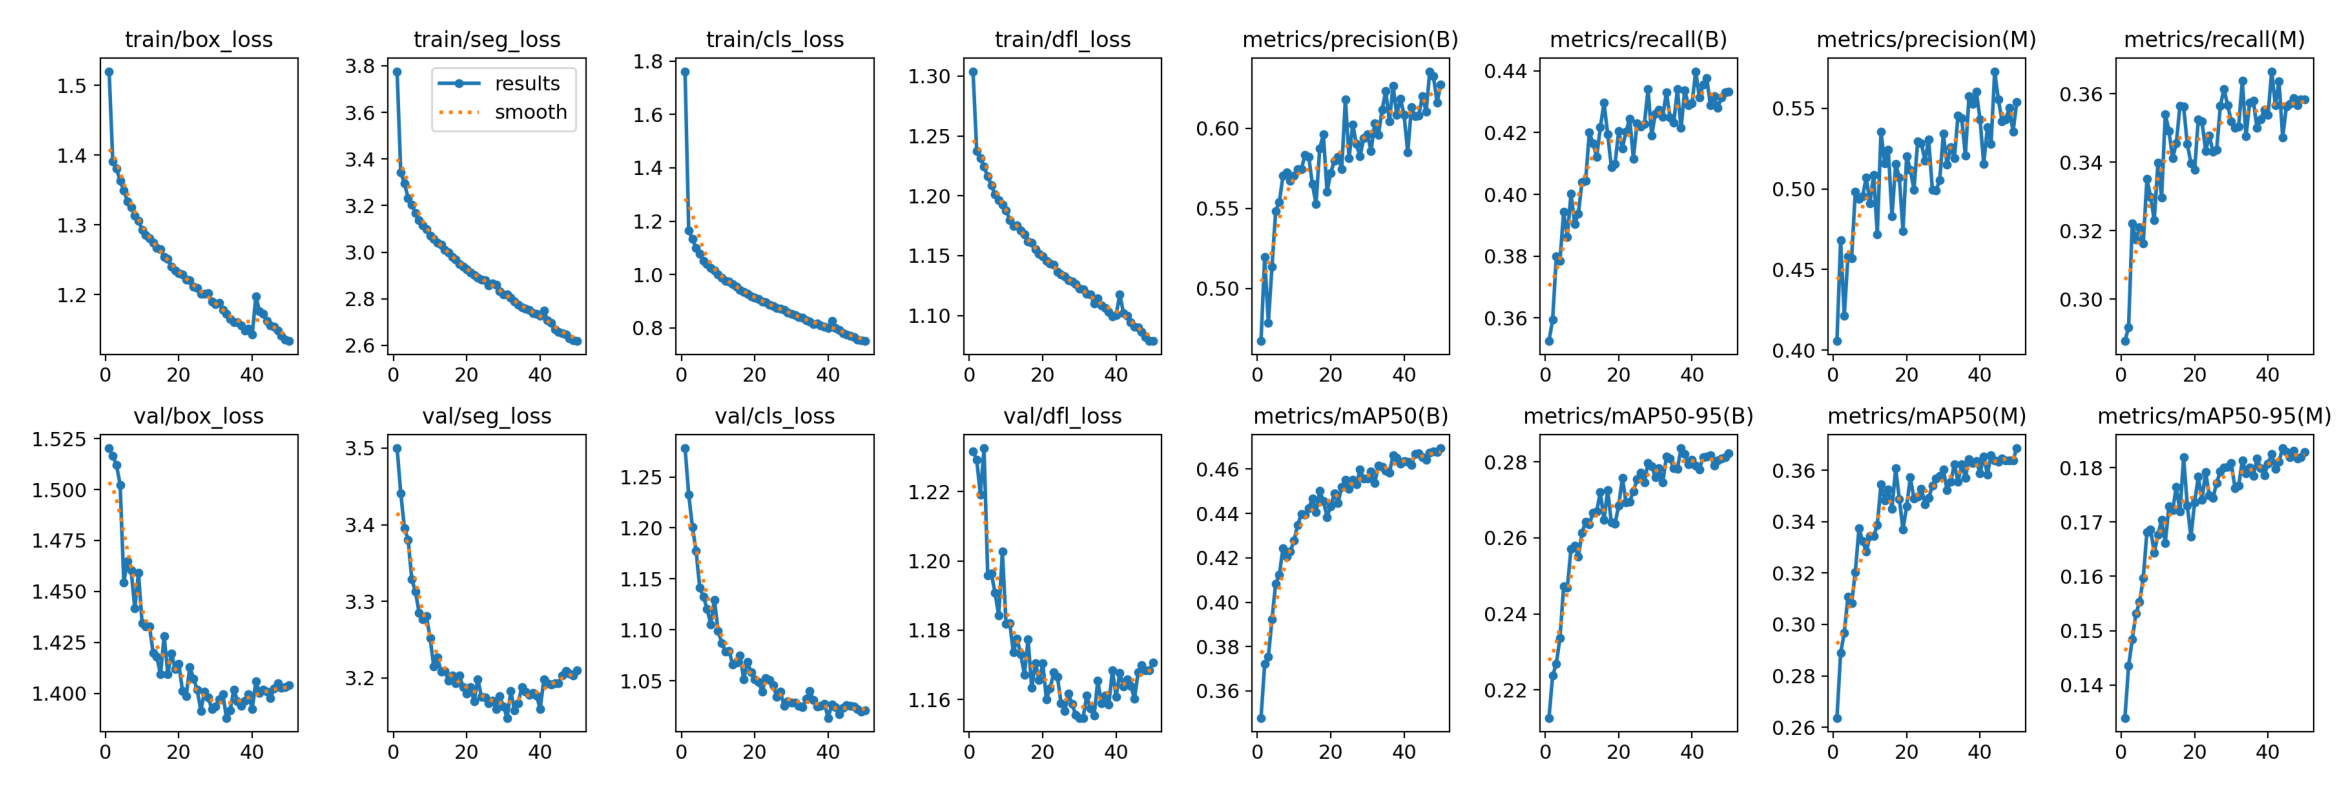

In [ ]:
fig = plt.figure(figsize=(30, 20))
plt.axis("off")
plt.imshow(PIL.Image.open("runs/segment/train/results.png"));

## Predicting on a test sample


image 1/1 /content/yolo/test/images/berlin_000000_000019_leftImg8bit.png: 320x640 1 road, 1 sidewalk, 1 building, 7 poles, 4 traffic lights, 2 traffic signs, 3 vegetations, 2 skys, 6 persons, 2 riders, 11 cars, 1 bus, 1 bicycle, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 5.6ms postprocess per image at shape (1, 3, 320, 640)


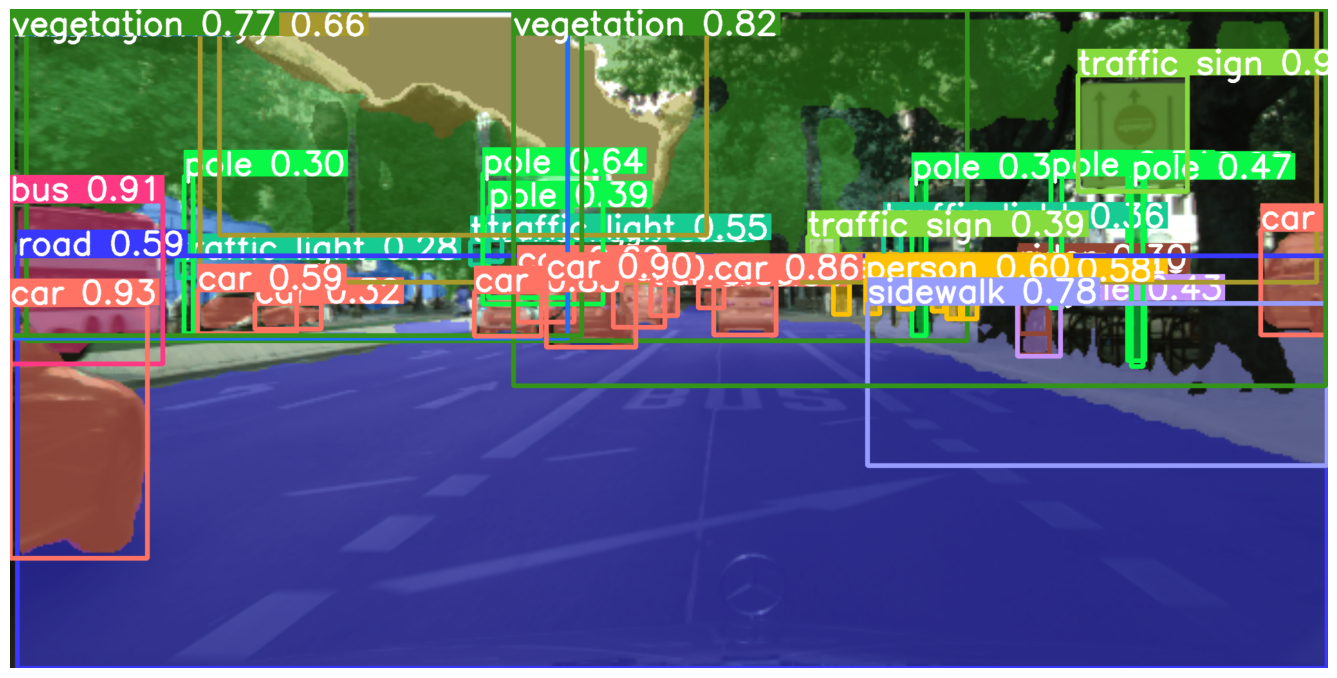

In [ ]:
# Predicting on a test image (show bounding box, mask, label, confidence), at default IoU threshold 0.7, condifdence threshold 0.25
model = YOLO("runs/segment/train/weights/best.pt")
predictions = model("yolo/test/images/berlin_000000_000019_leftImg8bit.png")

plt.figure(figsize=(17,10))
plt.axis("off")
plt.imshow(predictions[0].plot());

### This is how the sample looks like with only the masks
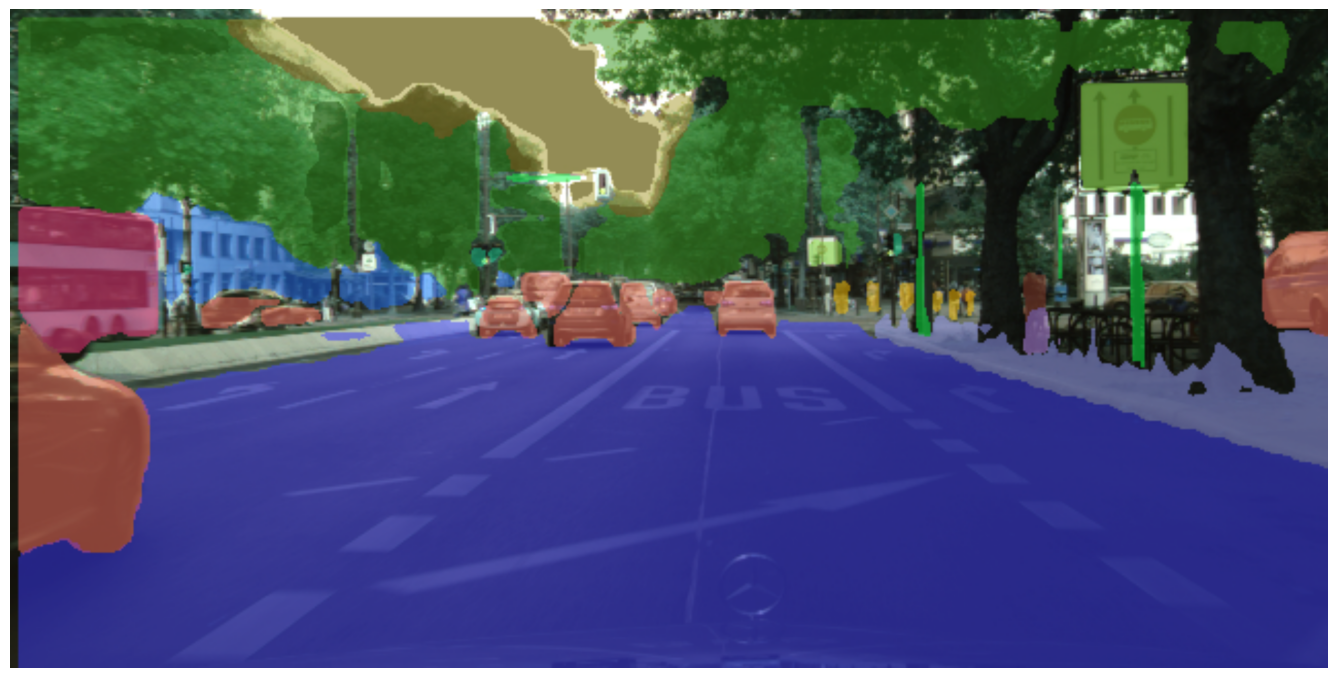

## We will be testing the model on real-time (using a video and also trying on our computer's webcam!). However, this requires access to our computer's webcam via opencv2, which cannot be done on Google Colab.

## Hence, we will continue with the testing of video and webcam, as well as the deployment in the next Jupyter notebook (which I will run locally on my computer).